In [1]:
# to find and check the hardware(GPU) situatuion, if you have no available GPUs, please no worries. This neural netwaork can run via CPU.
import torch
print(torch.cuda.is_available())  # to find available GPUs
print(torch.cuda.device_count()) # to count the number of GPUs
print(torch.cuda.get_device_name(0))  # To get name of the first available GPU

True
1
NVIDIA GeForce RTX 4070 SUPER


In [9]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# set hyperparaters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# load database
transform = transforms.Compose([
    transforms.ToTensor(),  # transfer images to tensors
    transforms.Normalize((0.5,), (0.5,))  # normalization
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# define a simple neural network
class DigitsRecogNN(nn.Module):
    def __init__(self):
        super(DigitsRecogNN, self).__init__()
        self.flatten = nn.Flatten()  # flatten layer, input layer
        self.fc1 = nn.Linear(28*28, 128)  # full connected layer
        self.relu = nn.ReLU() # response functions
        self.fc2 = nn.Linear(128, 10)  # full connected layer, output layer

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = DigitsRecogNN()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# record start time
start_time = time.time()

# training
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # upload data to GPU, if GPU is availavle
        data, targets = data.to('cpu'), targets.to('cpu')

        # forward propogation
        outputs = model(data)
        loss = criterion(outputs, targets)

        # back propagration
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# record end time
end_time = time.time()

# output traning time
train_time = end_time - start_time
print(f"Training Time: {train_time:.2f} seconds")

# test model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to('cpu'), targets.to('cpu')
        outputs = model(data)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/5], Loss: 0.2830
Epoch [2/5], Loss: 0.1422
Epoch [3/5], Loss: 0.2190
Epoch [4/5], Loss: 0.0811
Epoch [5/5], Loss: 0.0441
Training Time: 26.71 seconds
Test Accuracy: 96.97%


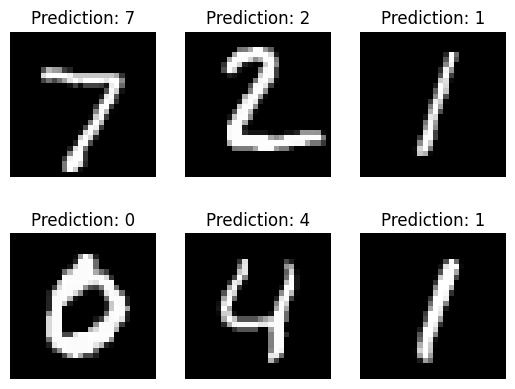

In [11]:
# visualization
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to('cpu')
    outputs = model(example_data)
    _, predicted = outputs.max(1)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(example_data[i].squeeze(), cmap='gray')
    plt.imshow(example_data[i][0], cmap='gray') # test, same as above
    plt.title(f"Prediction: {predicted[i].item()}")
    plt.axis('off')
plt.show()

In [16]:
# save the dictionary of the model
torch.save(model.state_dict(), 'DigitsRecognition.pth')